In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

Загрузим данные на каких будем тренироваться и тестировать

In [21]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)

Files already downloaded and verified


In [22]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
6


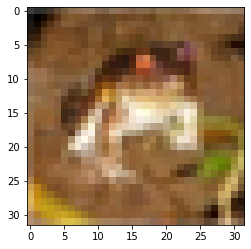

In [23]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [25]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [26]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

In [27]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Создадим класс для нашей модели и предусмотрим возможность менять параметры модели через входящие параметры:
- количество скрытых слоёв
- количество входящих нейронов
- количество нейронов на скрытом слое (по сути это коэфициент, на каждом слое будет разное количество нейронов)
- количество нейронов на выходном слое

In [28]:
class Net(nn.Module):
    def __init__(self, count_hidden, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc = nn.ModuleList()

        self.fc.append(nn.Linear(input_dim, count_hidden * hidden_dim))

        for index in range(count_hidden - 1, 0, -1):
          self.fc.append(nn.Linear((index + 1) * hidden_dim, index * hidden_dim))

        self.fc.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        for fc in self.fc:
          x = fc(x)
          x = F.leaky_relu(x)

        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        
        for fc in self.fc:
          x = fc(x)
          x = F.leaky_relu(x)

        x = F.softmax(x)
        return x

Вынесем постоянные параметры сети в константы и напишем функцию которая будет принимать на вход параметры для обучения

In [29]:
INPUT_DIM = 3 * 32 * 32
OUTPUT_DIM = len(classes)
NUM_EPOCHS = 30 

best_params = {}
best_accuracy = 0

In [30]:
def search(num_hidden_layers, hidden_dim, optim, lr):
  global best_accuracy
  global best_params

  print("/-----------------------------------------------------------------------------/")
  print(f"hiddenLayers: {num_hidden_layers}")
  print(f"hiddenDim: {hidden_dim}")
  print(f"optim: {optim}")
  print(f"lr: {lr}")
  print()

  net = Net(num_hidden_layers, INPUT_DIM, hidden_dim, OUTPUT_DIM)
  net.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim(net.parameters(), lr=lr)

  for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)

    print(f"Epoch [{epoch + 1}]: Loss: {running_loss / running_items:.3f}")
    running_loss, running_items = 0.0, 0.0

  print('Training is finished!')

  data_iter = iter(test_loader)
  images, labels = data_iter.next()

  net.eval()
  outputs = net(images)

  _, predicted = torch.max(outputs, 1)

  gt = np.array([classes[labels[j]] for j in range(len(labels))])
  pred = np.array([classes[predicted[j]] for j in range(len(labels))])
  accuracy = (gt == pred).sum() / len(gt)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_params = {"hiddenLayers": num_hidden_layers, "hiddenDim": hidden_dim, "optim": optim, lr: lr}

  print(gt)
  print(pred)
  print(f'Accuracy is {accuracy}')

Определим массивы параметров для поиска

In [31]:
hidden_layers = [1, 2, 3, 5]
hidden_dims = [10, 50, 100]
lrs = [0.01, 0.001]
optims = [optim.SGD, optim.Adam, optim.NAdam]

In [32]:
for num_layers in hidden_layers:
  for hidden_dim in hidden_dims:
     for lr in lrs:
       for optim in optims:
         search(num_layers, hidden_dim, optim, lr)

/-----------------------------------------------------------------------------/
hiddenLayers: 1
hiddenDim: 10
optim: <class 'torch.optim.sgd.SGD'>
lr: 0.01

Epoch [1]: Loss: 0.034
Epoch [2]: Loss: 0.032
Epoch [3]: Loss: 0.031
Epoch [4]: Loss: 0.030
Epoch [5]: Loss: 0.029
Epoch [6]: Loss: 0.028
Epoch [7]: Loss: 0.028
Epoch [8]: Loss: 0.028
Epoch [9]: Loss: 0.027
Epoch [10]: Loss: 0.027
Epoch [11]: Loss: 0.027
Epoch [12]: Loss: 0.027
Epoch [13]: Loss: 0.027
Epoch [14]: Loss: 0.027
Epoch [15]: Loss: 0.027
Epoch [16]: Loss: 0.027
Epoch [17]: Loss: 0.027
Epoch [18]: Loss: 0.026
Epoch [19]: Loss: 0.026
Epoch [20]: Loss: 0.026
Epoch [21]: Loss: 0.026
Epoch [22]: Loss: 0.026
Epoch [23]: Loss: 0.026
Epoch [24]: Loss: 0.026
Epoch [25]: Loss: 0.026
Epoch [26]: Loss: 0.026
Epoch [27]: Loss: 0.026
Epoch [28]: Loss: 0.026
Epoch [29]: Loss: 0.026
Epoch [30]: Loss: 0.026
Training is finished!
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['car' 'truck' 'ship' 'ship' 'deer' 'frog' 'cat' 'fro

In [33]:
best_accuracy

0.875

In [34]:
best_params

{0.01: 0.01, 'hiddenDim': 50, 'hiddenLayers': 3, 'optim': torch.optim.sgd.SGD}